In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de números flotantes a 3 decimales
pd.set_option('display.float_format','{:.3f}'.format)

# Estilo de visualización
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

## CARGA Y EXPLORACIÓN DE DATOS

In [3]:
# Carga de datos
data = pd.read_csv('datasets/Superstore.csv', date_parser='Order Date')
data.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
505,506,CA-2017-134978,11/12/2017,11/15/2017,Second Class,EB-13705,Ed Braxton,Corporate,United States,New York City,...,10024,East,OFF-BI-10003274,Office Supplies,Binders,"Avery Durable Slant Ring Binders, No Labels",15.920,5,0.200,5.373
1121,1122,US-2014-147627,1/20/2014,1/26/2014,Standard Class,HL-15040,Hunter Lopez,Consumer,United States,Jonesboro,...,72401,South,TEC-PH-10001061,Technology,Phones,Apple iPhone 5C,699.930,7,0.000,181.982
3118,3119,CA-2015-121720,6/11/2015,6/12/2015,First Class,JE-15610,Jim Epp,Corporate,United States,Lakeland,...,33801,South,FUR-CH-10003312,Furniture,Chairs,Hon 2090 �Pillow Soft� Series Mid Back Swivel/...,1123.920,5,0.200,-182.637
3605,3606,CA-2017-112956,8/21/2017,8/27/2017,Standard Class,TH-21550,Tracy Hopkins,Home Office,United States,Columbia,...,21044,East,FUR-FU-10004960,Furniture,Furnishings,"Seth Thomas 12"" Clock w/ Goldtone Case",91.920,4,0.000,31.253
4441,4442,US-2016-111290,7/22/2016,7/26/2016,Standard Class,DK-13375,Dennis Kane,Consumer,United States,Westland,...,48185,Central,OFF-ST-10001932,Office Supplies,Storage,Fellowes Staxonsteel Drawer Files,965.850,5,0.000,135.219


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.000,4997.500,2885.164,1.000,2499.250,4997.500,7495.750,9994.000
Postal Code,9994.000,55190.379,32063.693,1040.000,23223.000,56430.500,90008.000,99301.000
Sales,9994.000,229.858,623.245,0.444,17.280,54.490,209.940,22638.480
Quantity,9994.000,3.790,2.225,1.000,2.000,3.000,5.000,14.000
Discount,9994.000,0.156,0.206,0.000,0.000,0.200,0.200,0.800
Profit,9994.000,28.657,234.260,-6599.978,1.729,8.666,29.364,8399.976


In [6]:
data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

## TRANSFORMACIONES DE DATOS

In [7]:
# Datos de los corporativos
corporate_data = data[data.Segment=='Corporate']

# Transformación de tipo de dato
corporate_data['Order Date'] = pd.to_datetime(corporate_data['Order Date'])

# Seleccinar los datos del último año - 2017
corporate_data = corporate_data[corporate_data['Order Date'] >= '2017']

# Calculo de variable 'Discount'
corporate_data['Discount'] = corporate_data['Discount']  * corporate_data['Sales'] 

In [8]:
# Datos agrupados 
corporate_data = corporate_data.groupby(['Customer ID','Order ID','Order Date']).sum()
corporate_data.drop(['Row ID','Postal Code'], axis=1, inplace=True)
corporate_data = corporate_data.reset_index([0,1,2])

corporate_data.sample(3)

,Customer ID,Order ID,Order Date,Sales,Quantity,Discount,Profit
421,RS-19765,US-2017-100048,2017-05-19,889.290,11,0.000,313.025
188,ES-14080,CA-2017-139619,2017-09-19,95.616,2,19.123,9.562
279,KB-16240,CA-2017-142034,2017-09-24,1331.820,13,0.000,469.614


In [9]:
# CREATING RFM FEATURES
# =============================================================================================

snapshot_date = corporate_data['Order Date'].max() + dt.timedelta(days=1)

# Aggregate data on a customer level
corporateData = corporate_data.groupby('Customer ID').agg({'Order Date': lambda x: (snapshot_date - x.max()).days,
                                          'Order ID': 'count',
                                          'Sales': 'sum'})

# Rename columns
corporateData.rename(columns={'Order Date': 'Recency',
                        'Order ID': 'Frequency',
                        'Sales': 'MonetaryValue'}, inplace=True)

corporateData.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
GZ-14545,158,3,2408.362
JS-15685,43,2,693.724
MG-18205,265,1,16.739
AG-10495,79,1,114.376
SC-20440,37,3,502.688


#### VARIABLES SIN ESCALADO

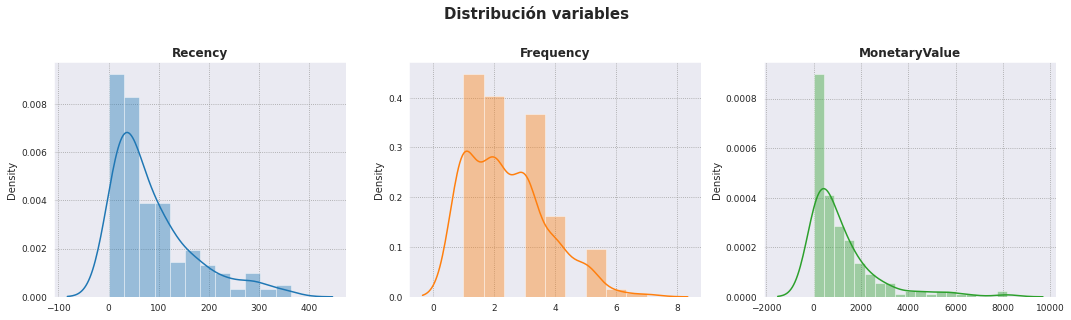

In [10]:
# DISTRIBUCIONES DE VARIABLES SIN ESCALAR
# ==============================================================================

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes = axes.flat

for i, feature in enumerate(corporateData.columns):
    sns.distplot(
        x       = corporateData[feature],
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(feature, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
fig.suptitle('Distribución variables', y=1.1,fontsize = 15, fontweight = "bold");

In [11]:
corporateData.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,204.000,87.098,80.515,1.000,29.000,58.000,119.250,363.000
Frequency,204.000,2.417,1.290,1.000,1.000,2.000,3.000,7.000
MonetaryValue,204.000,1185.529,1468.036,1.188,217.842,697.842,1518.147,8167.420


#### PREPROCESAMINETO DE VARIABLES

In [12]:
# Transformación logarítmica
corporateData_log = np.log(corporateData)

# x - X.mean / X.std
scaler = StandardScaler()

# 
scaler.fit(corporateData_log)

# Escalado de variables
scaled_features = scaler.transform(corporateData_log)

# Variables escaladas - DataFrame
scaled_features = pd.DataFrame(scaled_features, index=corporateData.index, columns=corporateData.columns)
scaled_features.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
MC-17590,-0.001,-1.327,-0.693
KE-16420,-0.562,-0.076,-0.360
MK-17905,-0.500,0.656,-1.065
DM-13345,-0.699,-0.076,1.115
LA-16780,0.932,-1.327,-0.847


#### VARIABLES ESCALADAS

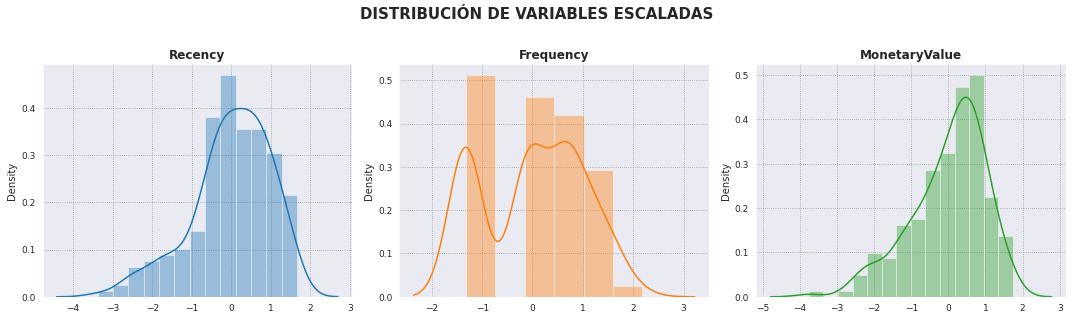

In [13]:
# DISTRIBUCIONES DE VARIABLES ESCALADAS
# ==============================================================================

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
axes = axes.flat


for i, feature in enumerate(scaled_features.columns):
    sns.distplot(
        x       = scaled_features[feature],
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(feature, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('DISTRIBUCIÓN DE VARIABLES ESCALADAS', y=1.1, fontsize = 15, fontweight = "bold");

In [14]:
scaled_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,204.000,0.000,1.002,-3.378,-0.500,0.092,0.708,1.659
Frequency,204.000,-0.000,1.002,-1.327,-1.327,-0.076,0.656,2.185
MonetaryValue,204.000,-0.000,1.002,-3.757,-0.515,0.210,0.693,1.740


## KMeans

#### MÉTODO DE CODO

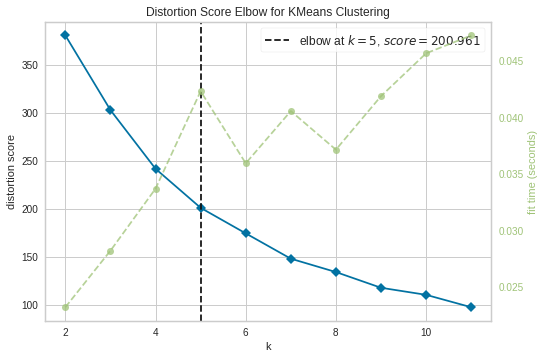

In [15]:
# MÉTODO DE CODO
# ============================================================================
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()


#### ENTRENAMIENTO DEL MODELO - KMEANS

In [16]:
# Modelo - KMeans
kmeans_model = KMeans(n_clusters=5)

# Modelo entrenado
kmeans_model.fit_transform(scaled_features)

corporateData['ClusterLabels_k5'] = kmeans_model.labels_

kmeansData = corporateData.groupby('ClusterLabels_k5').agg({'Recency':'mean',
                                           'Frequency':'mean',
                                           'MonetaryValue':['mean','count']})
kmeansData

Recency Frequency MonetaryValue      
                    mean      mean          mean count
ClusterLabels_k5                                      
0                 97.298     2.351       576.847    57
1                126.594     1.250        46.497    32
2                 59.193     3.719      2425.641    57
3                  6.680     2.960      1268.693    25
4                140.303     1.000      1136.388    33

## Hierarchical Clustering

In [17]:
# Modelo de segmentación jerárquica
hierarchy_model = linkage(scaled_features, method='ward')

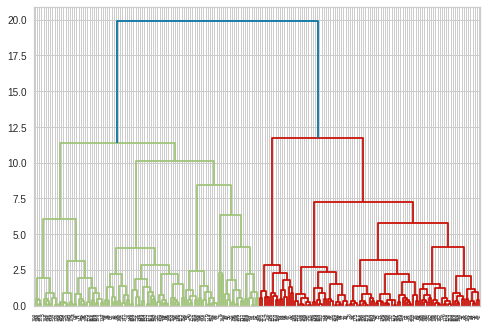

In [18]:
# Dendrograma
drendogram = dendrogram(hierarchy_model)

# Visualización del dendrograma
plt.show()

In [19]:
# Punto de corte
cluster_labels = fcluster(hierarchy_model, 9, criterion='distance')

hierarchicalData = corporateData.copy()

# Asignación de las etiquetas de clusters a los datos
hierarchicalData['ClusterLabels_H'] = cluster_labels

hierarchicalData = hierarchicalData.groupby('ClusterLabels_H').agg({'Recency':'mean',
                                                   'Frequency':'mean',
                                                   'MonetaryValue':['mean','count']})


hierarchicalData

Recency Frequency MonetaryValue      
                   mean      mean          mean count
ClusterLabels_H                                      
1               193.125     1.000       157.530    32
2                67.649     2.405       183.645    37
3                57.765     1.147      1172.732    34
4                 5.250     3.875      1893.507    16
5                82.788     3.188      1880.506    85